In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.labelsize"] = 14

## HCP 100 Subjects CNN with 3 Pipelines

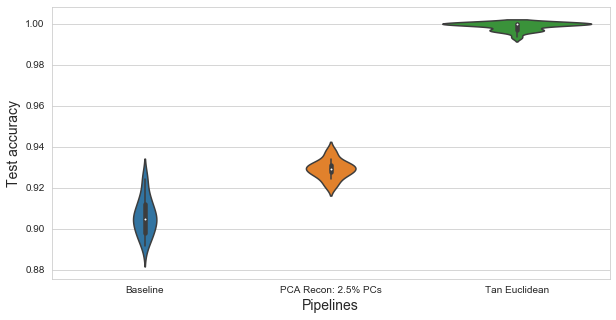

In [22]:
sns.set_style("whitegrid")
baseline = pd.read_csv('HCP100_base_E200_LR0.001_R1_S0_Y1_20.csv')
tan_euclidean = pd.read_csv('HCP100_Taneuclid_E200_LR0.001_R1_S0_Y1_20.csv')
pca_recon = pd.read_csv('HCP100_recon_0.025_E200_LR0.001_R0_S0_Y1.csv')
df = pd.concat([baseline['Accuracy'], pca_recon['Accuracy'],
                tan_euclidean['Accuracy']], axis=1,
               keys=['Baseline', 'PCA Recon: 2.5% PCs', 'Tan Euclidean'])
df = df.melt(var_name='Pipelines', value_name='Test accuracy')
ax = sns.violinplot(x="Pipelines", y="Test accuracy", data=df)
fig = ax.get_figure()
fig.set_size_inches(10,5)
plt.savefig('DL_pipelines.eps', bbox_inches='tight', transparent=True)
plt.show()

## Task Classification on Closest FC without DL

In [23]:
distances = pd.read_csv('distances_task.csv', names=["Type", "Accuracy"])
new = distances["Type"].str.rsplit("_", n = 1, expand = True) 
distances['Tangent Reference'] = new[0]
distances['Distance'] = new[1]
distances.drop(columns =["Type"], inplace = True) 
distances.head()

,Accuracy,Tangent Reference,Distance
0,0.891447,euclid,corr
1,0.875000,euclid,cosine
2,0.128289,euclid,euclidean
3,0.871711,harmonic,corr
4,0.907895,harmonic,cosine


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

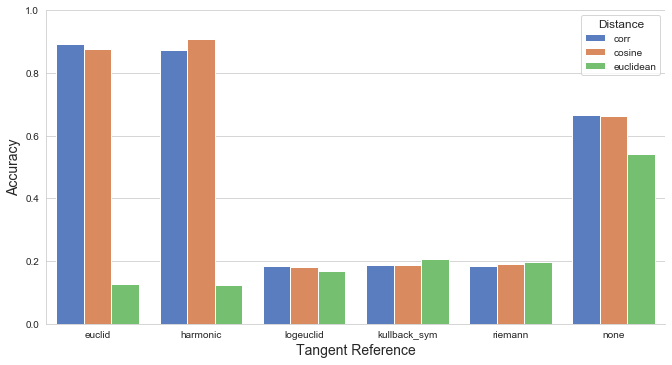

In [24]:
sns.set_style("whitegrid")
plt.tight_layout()
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=distances,
                height=6, kind="bar", palette="muted", legend_out=False).set(ylim=(0, 1))
ref_plot.fig.set_size_inches(10,5)
plt.savefig('distance_task.eps', bbox_inches='tight', transparent=True)
plt.show()

## Subject Classification on Closest FC without DL

In [25]:
distances = pd.read_csv('distances_subject.csv', names=["Type", "Accuracy"])
new = distances["Type"].str.rsplit("_", n = 1, expand = True) 
distances['Tangent Reference'] = new[0]
distances['Distance'] = new[1]
distances.drop(columns =["Type"], inplace = True) 
distances.head()

,Accuracy,Tangent Reference,Distance
0,0.019737,euclid,corr
1,0.019737,euclid,cosine
2,0.019737,euclid,euclidean
3,0.003289,harmonic,corr
4,0.003289,harmonic,cosine


<Figure size 432x288 with 0 Axes>

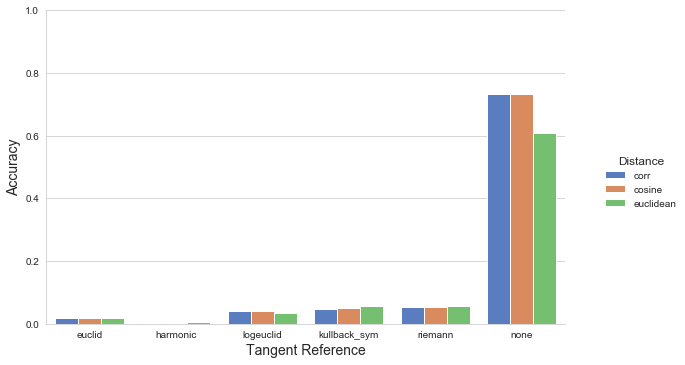

In [26]:

plt.tight_layout()
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=distances,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
#ref_plot.fig.suptitle('HCP100 Subject Classification Accuracy with Closest FC', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('distance_subj.png', bbox_inches='tight')
plt.show()

### KNN Classification, k = 30

In [27]:
knn_distances = pd.read_csv('knn_distances_task.csv', names=["Type", "Accuracy"])
new = knn_distances["Type"].str.rsplit("_", n = 1, expand = True) 
knn_distances['Tangent Reference'] = new[0]
knn_distances['Distance'] = new[1]
knn_distances.drop(columns =["Type"], inplace = True) 
knn_distances.head()

,Accuracy,Tangent Reference,Distance
0,0.868421,euclid,correlation
1,0.848684,euclid,cosine
2,0.125000,euclid,euclidean
3,0.875000,harmonic,correlation
4,0.875000,harmonic,cosine


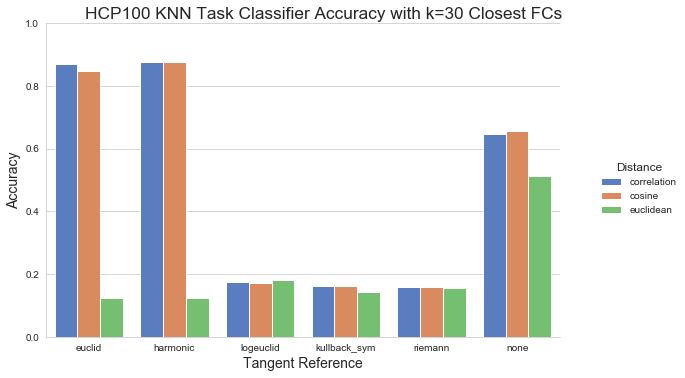

In [28]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=knn_distances,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('HCP100 KNN Task Classifier Accuracy with k=30 Closest FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('knn_classification.eps', bbox_inches='tight', transparent=True)
plt.show()

### Subject Classification - KNN 

In [29]:
knn_subject = pd.read_csv('knn_distances_subject.csv', names=["Type", "Accuracy"])
new = knn_subject["Type"].str.rsplit("_", n = 1, expand = True) 
knn_subject['Tangent Reference'] = new[0]
knn_subject['Distance'] = new[1]
knn_subject.drop(columns =["Type"], inplace = True) 
knn_subject.head()

,Accuracy,Tangent Reference,Distance
0,0.0,euclid,correlation
1,0.0,euclid,cosine
2,0.0,euclid,euclidean
3,0.0,harmonic,correlation
4,0.0,harmonic,cosine


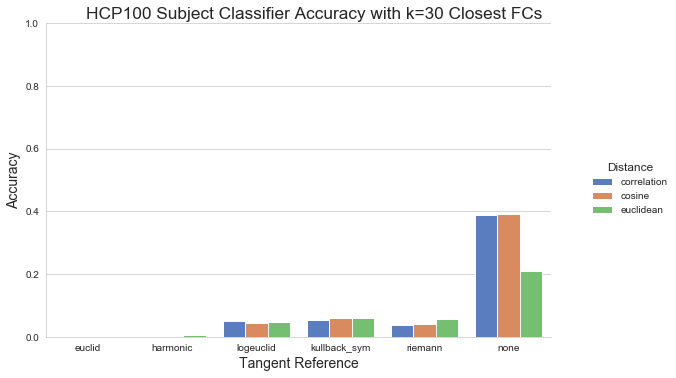

In [30]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=knn_subject,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('HCP100 Subject Classifier Accuracy with k=30 Closest FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('knn_subj.eps', bbox_inches='tight', transparent=True)
plt.show()

## Schaefer Parcellations

In [31]:
schaefer = pd.read_csv('schaefer_distances.csv', names=["Type", "Accuracy"])
new = schaefer["Type"].str.rsplit("_", n = 1, expand = True) 
schaefer['Parcellation'] = new[0]
schaefer['Tangent Reference'] = new[1]
schaefer.drop(columns =["Type"], inplace = True) 
schaefer.head()

,Accuracy,Parcellation,Tangent Reference
0,0.144853,Schaefer100,Euclid
1,0.152941,Schaefer100,Harmonic
2,0.809559,Schaefer100,None
3,0.136765,Schaefer200,Euclid
4,0.119118,Schaefer200,Harmonic


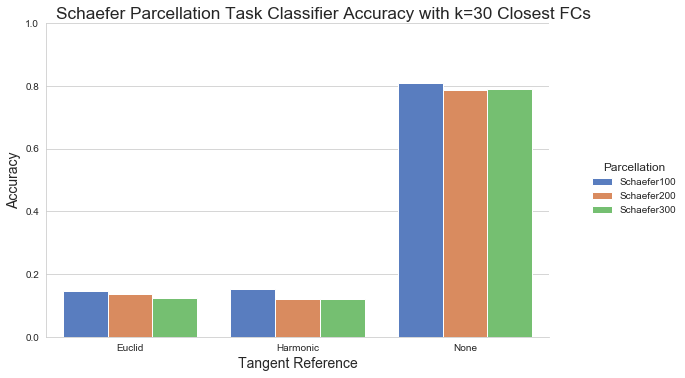

In [33]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Parcellation", data=schaefer,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('Schaefer Parcellation Task Classifier Accuracy with k=30 Closest FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('knn_task.eps', bbox_inches='tight', transparent=True)
plt.show()

In [34]:
def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8 * len(utri))) // 2
    iu1 = np.triu_indices(n)
    ret = np.empty((n, n))
    ret[iu1] = utri
    ret.T[iu1] = utri
    return ret

In [35]:
import pickle
with open('../data/schaefer.pickle', 'rb') as f:
    all_parc = pickle.load(f)

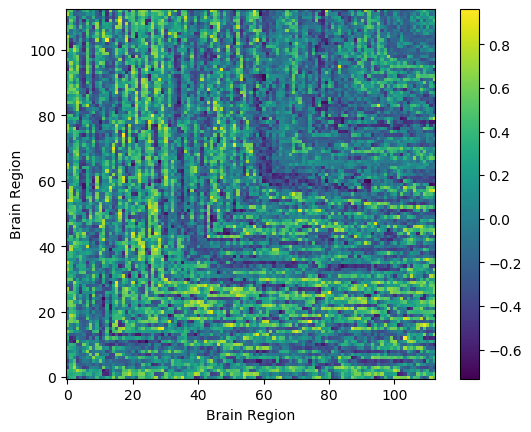

In [37]:
plt.style.use('default')
sampleFC = utri2mat(all_parc[100]['FC_all_vec'][0])
plt.imshow(sampleFC,origin='lower')
plt.colorbar()
plt.ylabel('Brain Region')
plt.xlabel('Brain Region')
plt.savefig('example_FC.eps', bbox_inches='tight', transparent=True)
plt.show()

In [63]:
schaefer_knn = pd.read_csv('schaefer_300_task_float32.csv', names=["Type", "Accuracy"])

In [64]:
new = schaefer_knn["Type"].str.rsplit("_", n = 1, expand = True) 
new2 = new[0].str.split("_", n = 1, expand = True) 

In [65]:
schaefer_knn['Parcellation'] = new[1]
schaefer_knn['Tangent Reference'] = new2[1]
schaefer_knn['K'] = new2[0]
schaefer_knn.drop(columns =["Type"], inplace = True) 
#schaefer_knn['K'] = schaefer_knn['K'].replace(['5'], '30')
schaefer_knn['K'] = schaefer_knn['K'].astype(int)

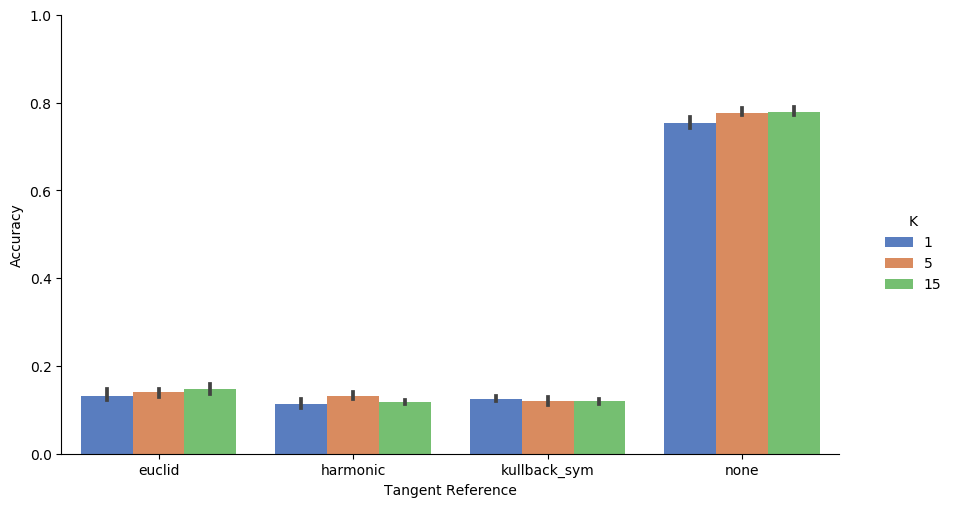

In [67]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="K", data=schaefer_knn,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.set_size_inches(10,5)
plt.savefig('schaefer_k.eps', bbox_inches='tight', transparent=True)
plt.show()